In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("ggplot")
import pandas as pd
import random as rand
import string
import math
chars = string.ascii_uppercase + string.digits
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)
import seaborn as sns
import sklearn as skl
import skimage as ski
from sklearn.preprocessing import LabelEncoder
from scipy import spatial
from sklearn.utils import shuffle

# setting up number of microsats and number of alleles per microsat

In [2]:
NMICROSATS = 5
NALLELEPERMICROSAT = 3

# generate new individuals functions

In [3]:


imagesize = np.array([100, 100])
population = pd.DataFrame(columns = ['Boldness', 'Sex', 'Age', 'Position'] + ['mSat'+ str(i+1).zfill(2) for i in range(NMICROSATS)])
population.index.name = 'name'

def generate_random_coyote(N):
    df = pd.DataFrame( columns = ['Boldness', 'Sex', 'Age'])
    df.index.name='name'
    for i in range(N):
        new_coyote = pd.DataFrame()
        new_coyote['name'] = ["Coyote"+"".join([rand.choice(chars) for k in range(6)])]
        new_coyote['Boldness'] = [rand.random()]
        new_coyote["Position"] = [np.array([rand.uniform(0,imagesize[0]-1),rand.uniform(0,imagesize[1]-1)])]
        new_coyote['Sex'] = np.random.choice(["male", "female"], 1)
        new_coyote['Age'] =  np.random.normal(3, 1., 1)
        for n in range(NMICROSATS):
            new_coyote["mSat"+ str(n+1).zfill(2)] = [tuple([rand.choice(string.ascii_uppercase[:NALLELEPERMICROSAT]), rand.choice(string.ascii_uppercase[:NALLELEPERMICROSAT])])]
        
        new_coyote = new_coyote.set_index(new_coyote.name)
        del new_coyote["name"]
        
        df =df.append(new_coyote)
    return df
        

    
def coyote_puppy(momma, poppa, N):
    global population
    df = pd.DataFrame( columns = ['Boldness', 'Sex', 'Age'])
    df.index.name='name'
    for i in range(N):
        puppy = pd.DataFrame()
        puppy['name'] = ["Coyote"+"".join([rand.choice(chars) for k in range(6)])]
        puppy['Boldness'] = [(momma.Boldness + poppa.Boldness)/2 +.05*rand.random()]
        puppy['Age'] =[.5]
        puppy["Position"] = [np.array([momma.Position[0]+rand.uniform(-3,3), momma.Position[1]+rand.uniform(-3,3)])]
        puppy['Sex'] = np.random.choice(["male", "female"], 1)
        for n in range(NMICROSATS): 
            puppy["mSat"+ str(n+1).zfill(2)] = [tuple([np.random.choice(momma["mSat"+ str(n+1).zfill(2)], 1)[0], np.random.choice(poppa["mSat"+ str(n+1).zfill(2)], 1)[0]])]
        
        puppy = puppy.set_index(puppy.name)
        del puppy["name"]
        df =df.append(puppy)
    
    population = pd.concat([population,df])
    


# Generate initial population

In [4]:
NMICROSATS = 5
NALLELEPERMICROSAT = 3

population = pd.concat([population, generate_random_coyote(100)])

population.head()


,Age,Boldness,Position,Sex,mSat01,mSat02,mSat03,mSat04,mSat05
name,,,,,,,,,
Coyote6RSIZG,3.463861,0.037998,"[94.518258976, 34.3332356649]",female,"(B, A)","(C, C)","(B, A)","(A, C)","(A, B)"
CoyoteORBI2M,2.471169,0.994332,"[21.9131359083, 4.21272330947]",male,"(B, C)","(A, A)","(C, A)","(C, C)","(A, A)"
Coyote573D9W,4.020724,0.441321,"[6.97299843319, 21.9900515016]",male,"(C, C)","(A, B)","(A, A)","(A, C)","(A, A)"
CoyotePD6RU8,3.810462,0.122674,"[81.2210484995, 91.7785637234]",female,"(B, A)","(B, A)","(C, B)","(B, C)","(C, B)"
Coyote85M4GE,1.484268,0.530752,"[31.2781180377, 9.50216182794]",female,"(B, A)","(A, A)","(A, C)","(A, C)","(B, A)"


In [5]:
population.iloc[2].Position[1]

21.99005150161722

In [6]:
coyote_puppy(population.iloc[2], population.iloc[1], 4)
population.tail()


,Age,Boldness,Position,Sex,mSat01,mSat02,mSat03,mSat04,mSat05
name,,,,,,,,,
Coyote2JDJKM,3.076354,0.613177,"[91.9207403894, 85.3508696292]",male,"(B, C)","(C, C)","(B, A)","(B, B)","(B, B)"
CoyoteSXYRHP,0.500000,0.759279,"[8.557298216, 22.5266359246]",female,"(C, C)","(A, A)","(A, A)","(A, C)","(A, A)"
CoyoteP0WPE9,0.500000,0.730404,"[5.01245340496, 19.5990485436]",male,"(C, C)","(B, A)","(A, A)","(A, C)","(A, A)"
Coyote1AIMVN,0.500000,0.752636,"[5.28687647126, 21.591291735]",female,"(C, C)","(B, A)","(A, A)","(C, C)","(A, A)"
CoyoteZLYPPQ,0.500000,0.729910,"[7.49263011155, 19.5703443438]",female,"(C, B)","(A, A)","(A, C)","(C, C)","(A, A)"


# Functions to calculate Heterozigosity

In [25]:
def Heterozigosity(loci):
    result = 0
    for i in population[loci].values:
        if i[0] == i[1]: result += 1
    return result/population.shape[0]

def AllHeterozigosity():
    return np.array([Heterozigosity(i) for i in ['mSat'+ str(i+1).zfill(2) for i in range(NMICROSATS)]])
        

# Plot individuals on grid

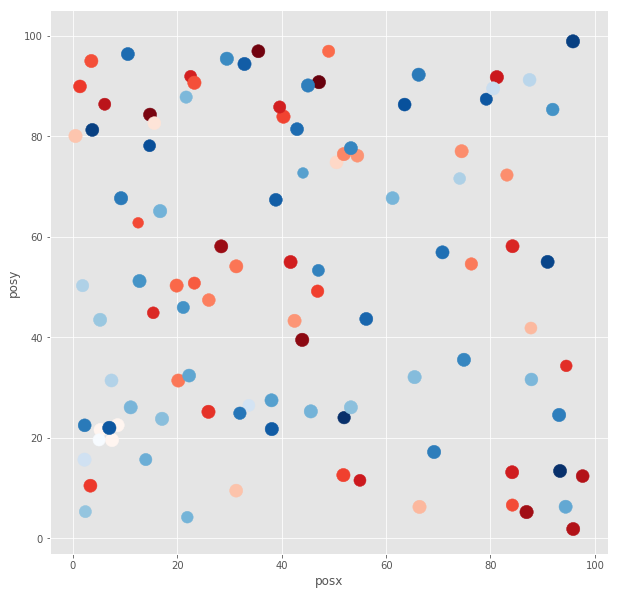

In [7]:
def plot_on_map():
    example = population.copy()
    example['posx'] = example.Position.apply(lambda x: x[0])
    example['posy'] = example.Position.apply(lambda x: x[1])
    ax = example[example.Sex == 'female'].plot.scatter('posx', 'posy', c = 'Age' , cmap = 'Reds',s = example.Boldness.apply(lambda x : math.log10(abs(x)*1000000)*30), colorbar = False)
    example[example.Sex == 'male'].plot.scatter('posx', 'posy', c = 'Age' , cmap = 'Blues',s = example.Boldness.apply(lambda x : math.log10(abs(x)*1000000)*30),colorbar = False,  ax =ax)

    

plot_on_map()

In [9]:
population.head()


,Age,Boldness,Position,Sex,mSat01,mSat02,mSat03,mSat04,mSat05
name,,,,,,,,,
Coyote6RSIZG,3.463861,0.037998,"[94.518258976, 34.3332356649]",female,"(B, A)","(C, C)","(B, A)","(A, C)","(A, B)"
CoyoteORBI2M,2.471169,0.994332,"[21.9131359083, 4.21272330947]",male,"(B, C)","(A, A)","(C, A)","(C, C)","(A, A)"
Coyote573D9W,4.020724,0.441321,"[6.97299843319, 21.9900515016]",male,"(C, C)","(A, B)","(A, A)","(A, C)","(A, A)"
CoyotePD6RU8,3.810462,0.122674,"[81.2210484995, 91.7785637234]",female,"(B, A)","(B, A)","(C, B)","(B, C)","(C, B)"
Coyote85M4GE,1.484268,0.530752,"[31.2781180377, 9.50216182794]",female,"(B, A)","(A, A)","(A, C)","(A, C)","(B, A)"


# function for migration

In [10]:
def migration(position, dt, age):
    global imagesize
    speed = [2,7,5,5,4,3,3,2,2,1,1,1,1,1,1,1][int(age)]
    angle = 2*math.pi*rand.random()
    distance = np.array([math.sin(angle), math.cos(angle)])*dt*speed
    pfx, pfy = position[0]+distance[0], position[1]+distance[1]
    
    
    if pfx > imagesize[0]: pfx = 2*imagesize[0] - (distance[0] + position[0]) 
    if pfy > imagesize[1]: pfy = 2*imagesize[1] - (distance[1] + position[1]) 
    if pfx < 0: pfx = abs(pfx)
    if pfy < 0: pfy = abs(pfy)
    
    return [pfx,pfy]

#testing
population["Position"]= population.apply(lambda x: migration(x['Position'], 1, x['Age']), axis = 1)
population.head()

    
    

,Age,Boldness,Position,Sex,mSat01,mSat02,mSat03,mSat04,mSat05
name,,,,,,,,,
Coyote6RSIZG,3.463861,0.037998,"[97.4290947271, 38.398581312]",female,"(B, A)","(C, C)","(B, A)","(A, C)","(A, B)"
CoyoteORBI2M,2.471169,0.994332,"[23.5478677485, 0.512491162962]",male,"(B, C)","(A, A)","(C, A)","(C, C)","(A, A)"
Coyote573D9W,4.020724,0.441321,"[6.64826990475, 18.0032543682]",male,"(C, C)","(A, B)","(A, A)","(A, C)","(A, A)"
CoyotePD6RU8,3.810462,0.122674,"[82.4011714811, 96.6372991297]",female,"(B, A)","(B, A)","(C, B)","(B, C)","(C, B)"
Coyote85M4GE,1.484268,0.530752,"[35.6107435574, 15.0001938491]",female,"(B, A)","(A, A)","(A, C)","(A, C)","(B, A)"


# Function for Aging

In [11]:
def aging(age , dt):
    return age + dt

population['Age'] = population["Age"].apply(lambda x: aging(x, 1/24/365))
population.head()

,Age,Boldness,Position,Sex,mSat01,mSat02,mSat03,mSat04,mSat05
name,,,,,,,,,
Coyote6RSIZG,3.463975,0.037998,"[97.4290947271, 38.398581312]",female,"(B, A)","(C, C)","(B, A)","(A, C)","(A, B)"
CoyoteORBI2M,2.471283,0.994332,"[23.5478677485, 0.512491162962]",male,"(B, C)","(A, A)","(C, A)","(C, C)","(A, A)"
Coyote573D9W,4.020838,0.441321,"[6.64826990475, 18.0032543682]",male,"(C, C)","(A, B)","(A, A)","(A, C)","(A, A)"
CoyotePD6RU8,3.810576,0.122674,"[82.4011714811, 96.6372991297]",female,"(B, A)","(B, A)","(C, B)","(B, C)","(C, B)"
Coyote85M4GE,1.484382,0.530752,"[35.6107435574, 15.0001938491]",female,"(B, A)","(A, A)","(A, C)","(A, C)","(B, A)"


# Function for Dieing

In [12]:
#calc probs of surviving for x years
print(.9987**365 * .9996**365 * .9996**365 * .9987**365 *.998**365 *.995**365)

#tested and working
def dieying(Age):
    prob_of_surviving_by_age_per_day = [.9987, .9996, .9996, .9987, .998, .995, .99, .985, .98, .977, .9, .0]
    prob_seeing_another_day = prob_of_surviving_by_age_per_day[int(Age)]
    if rand.random()>prob_seeing_another_day: return True
    return False

#using dieing function

def killsome():
    global population
    population['willdie'] = population['Age'].apply(dieying)
    population = population[population["willdie"]== False]
    del population['willdie']

print(population.shape)
killsome()
print(population.shape)
population.head()



0.022326420163582696
(104, 9)
(104, 9)


,Age,Boldness,Position,Sex,mSat01,mSat02,mSat03,mSat04,mSat05
name,,,,,,,,,
Coyote6RSIZG,3.463975,0.037998,"[97.4290947271, 38.398581312]",female,"(B, A)","(C, C)","(B, A)","(A, C)","(A, B)"
CoyoteORBI2M,2.471283,0.994332,"[23.5478677485, 0.512491162962]",male,"(B, C)","(A, A)","(C, A)","(C, C)","(A, A)"
Coyote573D9W,4.020838,0.441321,"[6.64826990475, 18.0032543682]",male,"(C, C)","(A, B)","(A, A)","(A, C)","(A, A)"
CoyotePD6RU8,3.810576,0.122674,"[82.4011714811, 96.6372991297]",female,"(B, A)","(B, A)","(C, B)","(B, C)","(C, B)"
Coyote85M4GE,1.484382,0.530752,"[35.6107435574, 15.0001938491]",female,"(B, A)","(A, A)","(A, C)","(A, C)","(B, A)"


# Function for giving birth 


In [13]:
def nearest_male(female):
    males = population[population['Sex'] == 'male']
    distances_list = np.array(males["Position"].values.tolist())
    distance,indexx = spatial.KDTree(distances_list).query(np.array(female['Position']))
    return males.iloc[indexx]
    

def procreate(female):
    global population
    breeding_ages = [[1 + x-(1/365)/2, 1+x +(1/365)/2] for x in range(1, 10)]
    is_breeding = False
    for i in breeding_ages: 
        if i[0]<female['Age']<i[1]: 
            if population.shape[0] <= 200:
                coyote_puppy(female, nearest_male(female), rand.randint(4,6) ) #if rand.random() > .9:
            
def birth():
    global population
    a = population[population['Sex'] == 'female'].copy()
    a = shuffle(a)
    for i in range(a.shape[0]): procreate(a.iloc[i])
    

# Function to Simulate a Day | Month | Year

In [14]:
def Aday():
    global population
    population['Age'] = population["Age"].apply(lambda x: aging(x, 1/365))
    killsome()
    birth()
    for i in range(24):
        population["Position"]= population.apply(lambda x: migration(x['Position'], 1, x['Age']), axis = 1)
        
def Amonth():
    global population
    for i in range(30): Aday()
        
def Ayear():
    global population
    for i in range(365): Aday()

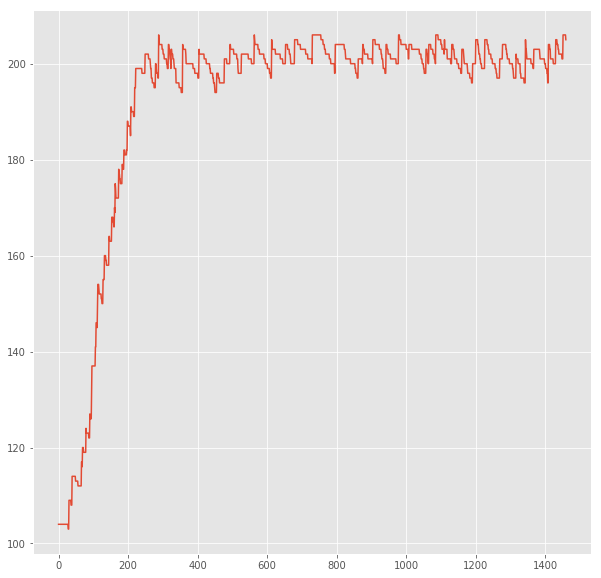

CPU times: user 4min 4s, sys: 244 ms, total: 4min 4s
Wall time: 4min 4s


In [15]:
%%time
a = []
temporal_heterozigosity = np.array()
for i in range(4*365):
    if i % 365: print("1 of a year passed")
    a += [population.shape[0]]
    Aday()
    
plt.plot(a)
plt.show()

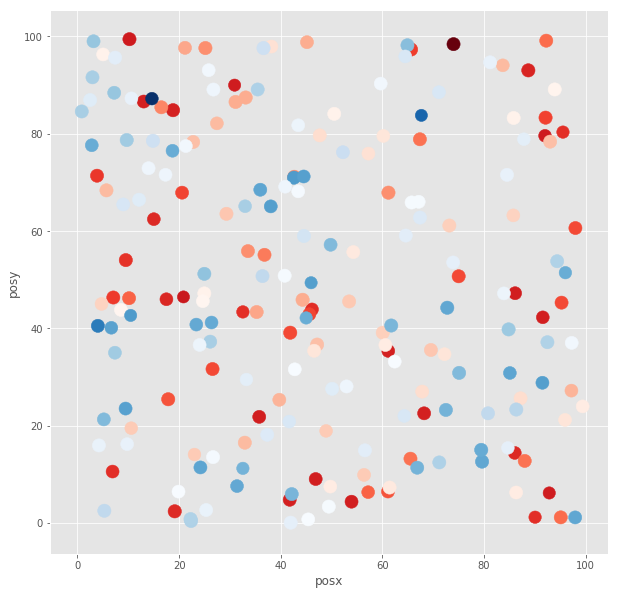

In [17]:
plot_on_map()

# Example plots

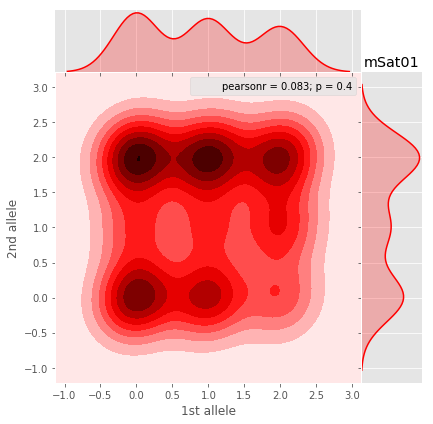

In [8]:
def plot_microsat_allele_dist(microsat, gray = 0):
    example = population.copy()
    example["1st allele"] = example[microsat].apply(lambda x : x[0] )
    example["2nd allele"] = example[microsat].apply(lambda x : x[1] )
    LE = LabelEncoder()
    LE.fit(example["1st allele"].values)

    LE2 = LabelEncoder()
    LE2.fit(example["1st allele"].values)
    example["1st allele"] = example["1st allele"].apply(lambda x : LE.transform([x])[0])
    example["2nd allele"] = example['2nd allele'].apply(lambda x : LE.transform([x])[0])
    if gray == 1: 
        (sns.jointplot("1st allele", "2nd allele", data=example, color="k").plot_joint(sns.kdeplot, zorder=0, n_levels=6))
        plt.title(microsat)
        return 
    sns.jointplot("1st allele", "2nd allele", data=example, kind="kde", space=0, color="red")
    plt.title(microsat)


    
    
plot_microsat_allele_dist('mSat01')

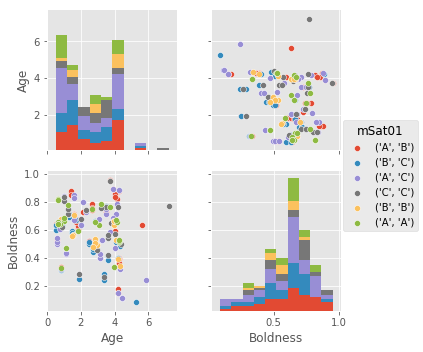

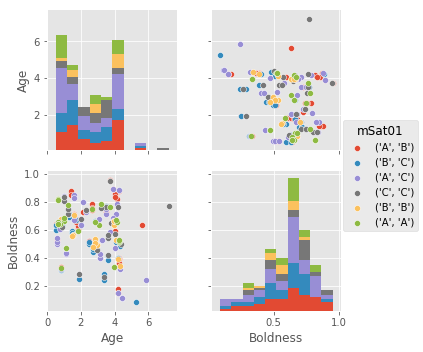

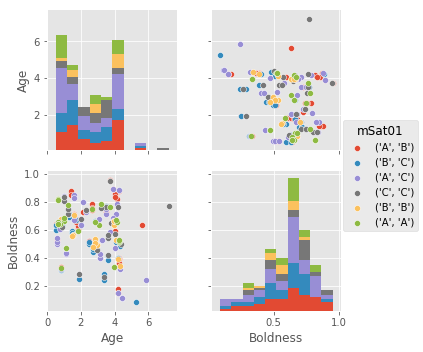

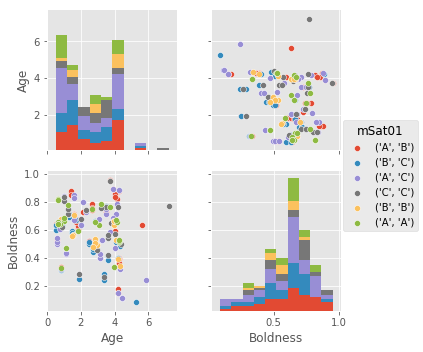

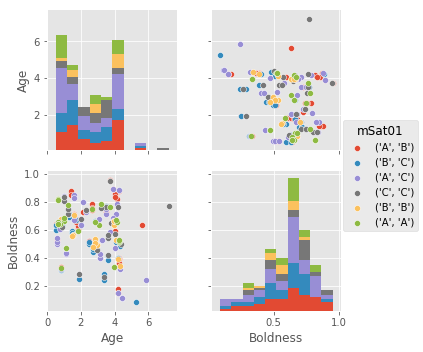

In [31]:
def fuse_equivalents(tup_alleles):
    return tuple(np.sort([tup_alleles[0], tup_alleles[1]]))

plt.rcParams["figure.figsize"] = (3.5,3.5)
example = population.copy()
for i in ['mSat'+ str(i+1).zfill(2) for i in range(NMICROSATS)]:
    example[i] = example[i].apply(fuse_equivalents)
    sns.pairplot(example, hue='mSat01')
    plt.show()

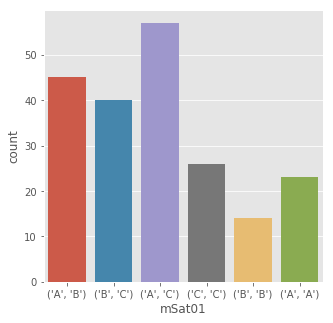

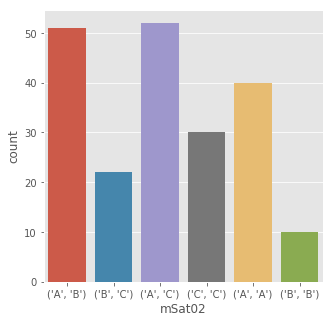

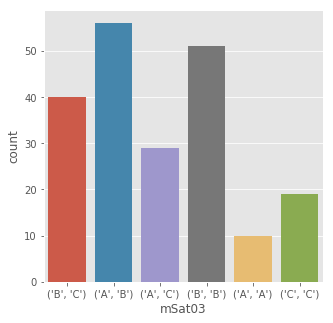

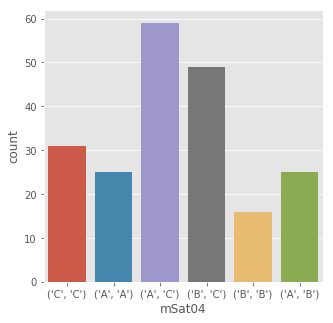

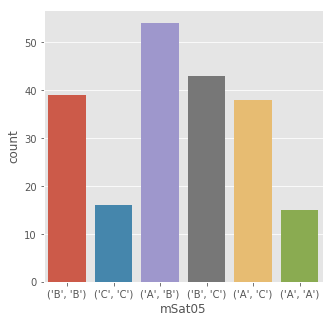

In [19]:
def fuse_equivalents(tup_alleles):
    return tuple(np.sort([tup_alleles[0], tup_alleles[1]]))

plt.rcParams["figure.figsize"] = (5,5)
example = population.copy()
for i in ['mSat'+ str(i+1).zfill(2) for i in range(NMICROSATS)]:
    example[i] = example[i].apply(fuse_equivalents)
    sns.countplot(x=i, data=example)
    plt.show()
    


In [26]:
AllHeterozigosity()

array([ 0.30731707,  0.3902439 ,  0.3902439 ,  0.35121951,  0.34146341])

In [ ]:
 TemporalDF = pd.